# Boosting

### Задание 1.

Мы упоминали о том, что у функция потерь AdaBoost имеет более жесткий штраф по отношению к ошибкам классификации, чем другие часто используемые функции. Реализуйте функции logloss и AdaBoost loss, которые возвращают значения штрафов, и посмотрите по графику, насколько сильно они отличаются (примем x = y * y^).

Теперь разберемся с тем, какие функции потерь мы можем использовать в задаче классификации. Так как оптимизировать сами метки класса довольно затруднительно, обычно используют пороговые значения, когда $\hat{y} \in \{-1, 1\}$. Наиболее известные функции потерь в классификации:
- Logistic loss или логистическая функция потерь: $L(y, \hat{y}) = log(1 + exp(-y \hat{y}))$ - самая используемая функция потерь в бинарной классификации;
- AdaBoost loss: $L(y, \hat{y}) = exp(-y \hat{y})$. Здесь нужно вспомнить про алгоритм AdaBoost: так получилось, что он эквивалентен методу градиентного бустинга с этой функцией потерь. Эта функция имеет более жесткий штраф по отношению к ошибкам классификации и используется реже.

В качестве базовых алгоритмов здесь обычно используются решающие деревья. При этом решающие деревья выбираются неглубокими: глубина варьируется от 2 до 7. Этого вполне достаточно, чтобы восстановить сложные закономерности с помощью бустинга.

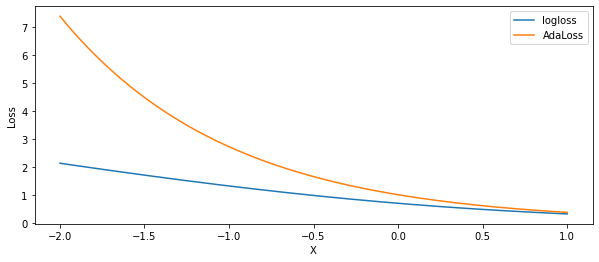

In [8]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

x = np.linspace(-2, 1, 300)

def logloss(x):
    return np.log(1+np.exp(-x))

def AdaLoss(x):
    return np.exp(-x)

plt.figure(figsize=(10, 4))
plt.plot(x, logloss(x), label='logloss')
plt.plot(x, AdaLoss(x), label='AdaLoss')
plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('Loss')

x_check = np.array([-2, 0, 2])
y_log = np.array([2.127, 0.693, 0.127])
y_ada = np.array([7.389, 1., 0.135])

assert np.allclose(logloss(x_check), y_log, atol=1e-3), f'Function logloss is not verified'
assert np.allclose(AdaLoss(x_check), y_ada, atol=1e-3), f'Function AdaLoss is not verified'

### Задание 2.

Когда дело доходит до оптимизации алгоритма, зачастую достаточно сложно подобрать сразу такие параметры, при которых качество классификатора было бы максимальным. В этом помогает либо опыт работы с различными методами, либо уже отмеченные другими специалистами взаимосвязи между количеством данных, самим алгоритмом, различными гиперпараметрами и т.п.

В случае с бустингом было отмечено, что количество деревьев, при котором качество алгоритма максимально, зависит от темпа обучения: чем меньше темп, тем больше деревьев обычно требуется. 

В этом задании попробуйте последовательно подобрать такие гиперпараметры n_estimators и learning_rate в алгоритме GBC, чтобы accuracy была равна 1: сначала последовательно увеличивайте количество базовых деревьев, не меняя при этом learning_rate, а затем поменяйте количество деревьев снова на 1 и уже меняйте гиперпараметр learning_rate в пределах (0, 1), не включая границы. Если  accuracy не будет равна 1 при граничном значении learning_rate, добавляйте по одному базовому алгоритму и смотрите, что получится (напомним, что зависимость нелинейная - при значительном увеличении learning_rate количество деревьев может увеличиться всего на одну-две позиции.

Сначала запустите следующий код со сгенерированными данными.

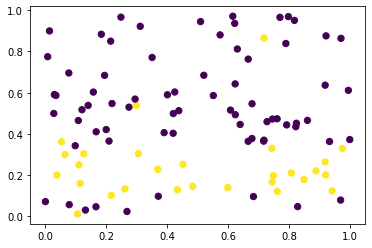

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def plot(alg, data, target):
    xx, yy = np.meshgrid(np.linspace(0., 1., 100), np.linspace(0., 1., 100))
    Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.bwr, alpha=0.3)
    
    plt.scatter(data[:, 0], data[:, 1], s=20, c=targets)
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    

np.random.seed(15)
data = np.random.rand(100, 2)
targets = np.empty(100)
targets[1 / data[:, 1] > 2] = 1
targets[1 / data[:, 1] < 3] = 0
targets[1 / data[:, 1] > 10] = 0
targets[[1, 3, 6, 15, 36]] = 1

plt.scatter(data[:, 0], data[:, 1], s=40, c=targets)

В следующей ячейке можете подбирать параметры алгоритма.

Комментарий от студента:

Подобраны параметры n_estimators и learning_rate методом перебора. Отфильтрованы результаты по двум ключам - score и time. Таким образом отобран не только самый лучший, но и самый быстрый алгоритм.

Accuracy: 1.0, n_estimators: 3, learning_rate: 0.6663333333333333


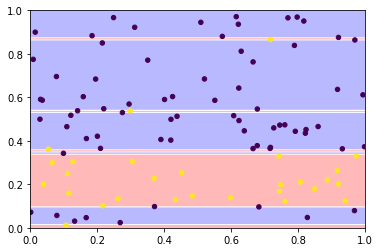

In [40]:
import time
result = []
for lr in np.linspace(0.001, .999, 100):
    for n_est in range(1,8):
        start = time.time()
        gbc = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr, random_state=42) # подгонка гиперпараметров
        model = gbc.fit(data, targets)
        pred = gbc.predict(data)
        score = {'lr':lr, 'n_est':n_est, 'score':accuracy_score(targets, pred), 'time':(time.time()-start)*-1}
        result.append(score)

result = sorted(result, key=lambda k: (k['score'], k['time']), reverse=True) 
best_ = result[0]
gbc = GradientBoostingClassifier(n_estimators=best_['n_est'], learning_rate=best_['lr']) # подгонка гиперпараметров
model = gbc.fit(data, targets)
pred = gbc.predict(data)
plot(gbc, data, targets)
print(f"Accuracy: {accuracy_score(targets, pred)}, n_estimators: {best_['n_est']}, learning_rate: {best_['lr']}")

In [41]:
result

[{'lr': 0.6663333333333333,
  'n_est': 3,
  'score': 1.0,
  'time': -0.0009963512420654297},
 {'lr': 0.9485959595959595,
  'n_est': 2,
  'score': 1.0,
  'time': -0.0009963512420654297},
 {'lr': 0.999, 'n_est': 3, 'score': 1.0, 'time': -0.000997304916381836},
 {'lr': 0.9183535353535354,
  'n_est': 2,
  'score': 1.0,
  'time': -0.000997781753540039},
 {'lr': 0.8981919191919192,
  'n_est': 2,
  'score': 1.0,
  'time': -0.0009980201721191406},
 {'lr': 0.7973838383838384,
  'n_est': 3,
  'score': 1.0,
  'time': -0.0010755062103271484},
 {'lr': 0.9284343434343434,
  'n_est': 2,
  'score': 1.0,
  'time': -0.0019655227661132812},
 {'lr': 0.7066565656565656,
  'n_est': 3,
  'score': 1.0,
  'time': -0.001977205276489258},
 {'lr': 0.7873030303030303,
  'n_est': 3,
  'score': 1.0,
  'time': -0.0019860267639160156},
 {'lr': 0.9284343434343434,
  'n_est': 4,
  'score': 1.0,
  'time': -0.0019881725311279297},
 {'lr': 0.23285858585858585,
  'n_est': 4,
  'score': 1.0,
  'time': -0.001993417739868164},